In [ ]:
import torch
import joblib
from pathlib import Path

PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "model_training").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

print("📁 Project root:", PROJECT_ROOT)

# ------------------------------------------------------
# 2. DEFINISCI PATH STANDARD
# ------------------------------------------------------
TRAINING_DIR   = PROJECT_ROOT / "model_training" / "training"
MODELS_DIR     = TRAINING_DIR / "models"
ARTIFACTS_DIR  = TRAINING_DIR / "artifacts"

CHECKPOINT_PATH = MODELS_DIR / "best_model.pt"
SCALER_PATH     = ARTIFACTS_DIR / "scaler.joblib"

print("📦 Checkpoint:", CHECKPOINT_PATH)
print("📦 Scaler    :", SCALER_PATH)

# ------------------------------------------------------
# 3. DEVICE
# ------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥 Device:", device)

# ------------------------------------------------------
# 4. IMPORT MODELLO (dopo aver sistemato i path)
# ------------------------------------------------------
import sys
sys.path.insert(0, str(TRAINING_DIR))

from models.GNN_Transformer.st_gnn_transformer import STGNNTransformer

# ------------------------------------------------------
# 5. LOAD CHECKPOINT (SOLO PYTORCH OBJECTS)
# ------------------------------------------------------
checkpoint = torch.load(
    CHECKPOINT_PATH,
    map_location=device,
    weights_only=False
)

config       = checkpoint["config"]
feature_cols = checkpoint["feature_cols"]

print("✅ Checkpoint loaded")
print("   Num features:", len(feature_cols))

# ------------------------------------------------------
# 6. RICOSTRUISCI MODELLO
# ------------------------------------------------------
num_nodes = len(feature_cols)
init_adj = torch.ones(num_nodes, num_nodes)

model = STGNNTransformer(config, init_adj)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

print("🤖 Model loaded and ready")

# ------------------------------------------------------
# 7. LOAD SCALER (joblib, separato)
# ------------------------------------------------------
scaler = joblib.load(SCALER_PATH)
print("📏 Scaler loaded and ready")

# ------------------------------------------------------
# 8. TUTTO PRONTO
# ------------------------------------------------------
print("\n✅ INFERENCE SETUP COMPLETATO CORRETTAMENTE")

📁 Project root: /Users/gabrielenatale/Desktop/Python_Project
📦 Checkpoint: /Users/gabrielenatale/Desktop/Python_Project/model_training/training/models/best_model.pt
📦 Scaler    : /Users/gabrielenatale/Desktop/Python_Project/model_training/training/artifacts/scaler.joblib
🖥 Device: cpu
✅ Checkpoint loaded
   Num features: 14
🤖 Model loaded and ready
📏 Scaler loaded and ready

✅ INFERENCE SETUP COMPLETATO CORRETTAMENTE


In [22]:
import pandas as pd


df = pd.read_csv(
    "../model_training/data/train_FD001.txt",
    sep=r"\s+",
    header=None
)

df.columns = (
    ["id", "cycle"] +
    ["setting1", "setting2", "setting3"] +
    [f"sensor{i}" for i in range(1, 22)]
)

print("Dataset loaded:", df.shape)
df.head()

Dataset loaded: (20631, 26)


,id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


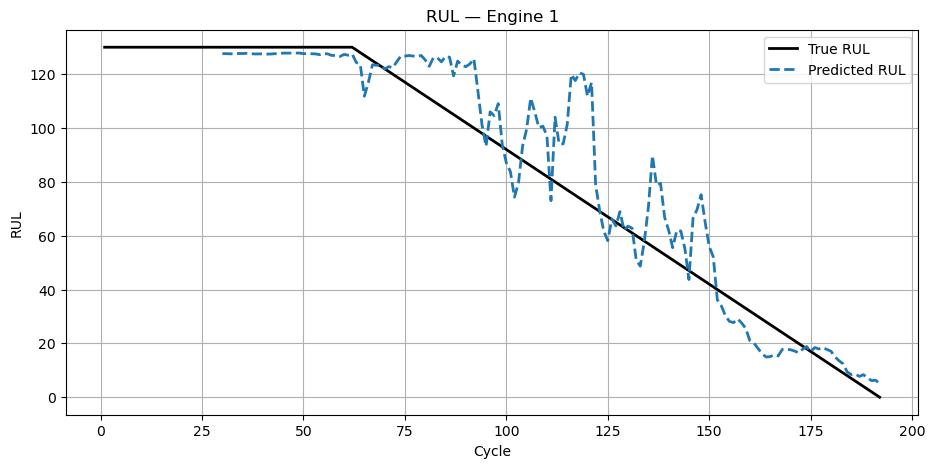

In [ ]:
max_cycles = df.groupby("id")["cycle"].max()
df["RUL"] = df["id"].map(max_cycles) - df["cycle"]

import numpy as np
import matplotlib.pyplot as plt
from engine_manager import EngineManager

ENGINE_ID   = 1
WINDOW_SIZE = config.get("window_size", 30)

manager = EngineManager(
    model=model,
    scaler=scaler,
    feature_cols=feature_cols,
    window_size=WINDOW_SIZE,
    device=device
)

manager.engine_states = {}

engine_df = (
    df[df["id"] == ENGINE_ID]
    .sort_values("cycle")
    .reset_index(drop=True)
)

cycles   = []
pred_rul = []
true_rul = []

for _, row in engine_df.iterrows():

    event = {
        "engine_id": ENGINE_ID,
        "cycle": int(row["cycle"]),
        "features": row[feature_cols].values.astype(np.float32)
    }

    predictions = manager.process_events([event])

    cycles.append(row["cycle"])
    true_rul.append(min(row["RUL"], 130))

    if len(predictions) > 0:
        pred_rul.append(predictions[0]["rul_prediction"])
    else:
        pred_rul.append(np.nan)


plt.figure(figsize=(11, 5))

plt.plot(
    cycles,
    true_rul,
    label="True RUL",
    linewidth=2,
    color="black"
)

plt.plot(
    cycles,
    pred_rul,
    label="Predicted RUL",
    linewidth=2,
    linestyle="--"
)

plt.xlabel("Cycle")
plt.ylabel("RUL")
plt.title(f"RUL — Engine {ENGINE_ID}")
plt.grid(True)
plt.legend()
plt.show()